<a href="https://colab.research.google.com/github/Debdutta0507/Deep-Single-Shot-Musical-Instrument-IdentificationUsing-Time-Frequency-Localized-Features/blob/master/resnet%2Bsiamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf 
tf.test.gpu_device_name()



''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os 
  
if 'COLAB_TPU_ADDR' not in os.environ: 
  print('Not connected to TPU') 
else: 
  print("Connected to TPU")

Not connected to TPU


In [ ]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,ZeroPadding2D,Activation,Add,AveragePooling2D
from keras.models import Model, Sequential
from keras.layers import merge
from keras.layers import Dropout,BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import time
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.layers import Lambda
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50

def initialize_weights(shape,dtype=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,dtype=dtype)
#//TODO: figure out how to initialize layer biases in keras.
def initialize_bias(shape,dtype=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,dtype=dtype)


def identity_block(X,f,filters):
   # conv_name_base = 'res' + str(stage) + block + '_branch'
    #bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1,F2,F3=filters
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer =initialize_weights)(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters= F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer = initialize_weights)(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer=initialize_weights)(X)
    X = BatchNormalization(axis=3)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X
def convolutional_block(X, f, filters, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    #conv_name_base = 'res' + str(stage) + block + '_branch'
   # bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s),kernel_initializer = initialize_weights)(X)
    X = BatchNormalization(axis = 3,)(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2,(f,f),strides=(1,1),padding='same',kernel_initializer=initialize_weights)(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3,(1,1),strides=(1,1),kernel_initializer=initialize_weights)(X)
    X = BatchNormalization(axis=3)(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3,(1,1),strides=(s,s),kernel_initializer=initialize_weights)(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    
    ### END CODE HERE ###
    
    return X



def ResNet50(input_shape, classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    #input_shape = (224, 224, 3)
    
    
    # Define the input as a tensor with shape input_shape
    #X_input = Input(input_shape)
    X_shortcut =Input(shape=input_shape)
    
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_shortcut)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer =initialize_weights,bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    ### START CODE HERE ###
    
    # Stage 3 (≈4 lines)
    X = convolutional_block(X,f=3,filters=[128,128,512],s=2)
    X = identity_block(X,3,filters=[128,128,512])
    X = identity_block(X,3,filters=[128,128,512])
    X = identity_block(X,3,filters=[128,128,512])
    
    # Stage 4 (≈6 lines)
    X = convolutional_block(X,f=3,filters=[256, 256, 1024],s=2)
    X = identity_block(X,3,filters=[256, 256, 1024])
    X = identity_block(X,3,filters=[256, 256, 1024])
    X = identity_block(X,3,filters=[256, 256, 1024])
    X = identity_block(X,3,filters=[256, 256, 1024])
    X = identity_block(X,3,filters=[256, 256, 1024])
    
    # Stage 5 (≈3 lines)
    X = convolutional_block(X,f=3,filters=[512,512,2048],s=2)
    X = identity_block(X,3,filters=[512,512,2048])
    X = identity_block(X,3,filters=[512,512,2048])
    
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2))(X)
    
    ### END CODE HERE ###
    
    # output layer
    X = Flatten()(X)
    #X=(Dense(4096, activation='sigmoid',
                   #kernel_regularizer=l2(1e-3),
                  # kernel_initializer=initialize_weights,bias_initializer=initialize_bias,name='dense'))(X)
    # X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    return Model( X_shortcut,X)

def get_siamese_model(input_shape):
    input_shape = (224, 224, 3)
    base_network=ResNet50(input_shape)
    left_input=Input(input_shape)
    right_input=Input(input_shape)
    encoded_l=base_network(left_input)
    encoded_r =base_network(right_input)
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net





    
    
    

'''
def get_siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    input_shape = (224, 224, 3)
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4),name='conv1'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4),name='conv2'))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (4,4), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4),name='conv3'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4),name='conv4'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias,name='dense'))
    model.add(Dropout(0.2))
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net
'''



Using TensorFlow backend.


'\ndef get_siamese_model(input_shape):\n    """\n        Model architecture\n    """\n    \n    # Define the tensors for the two input images\n    input_shape = (224, 224, 3)\n    left_input = Input(input_shape)\n    right_input = Input(input_shape)\n    \n    # Convolutional Neural Network\n    model = Sequential()\n    \n    model.add(Conv2D(64, (10,10), activation=\'relu\', input_shape=input_shape,\n                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4),name=\'conv1\'))\n    model.add(MaxPooling2D())\n    \n    model.add(Conv2D(128, (7,7), activation=\'relu\',\n                     kernel_initializer=initialize_weights,\n                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4),name=\'conv2\'))\n    model.add(MaxPooling2D())\n\n    model.add(Conv2D(128, (4,4), activation=\'relu\',\n                     kernel_initializer=initialize_weights,\n                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4),name

In [ ]:
siamese_net=get_siamese_model(1)

optimizer = Adam(0.00003)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()
siamese_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 18432)        23587712    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 18432)        0           model_1[1][0]              

In [ ]:
'''epochs = 8000
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum = 0.7
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
siamese_net.compile(loss='binary_crossentropy', optimizer=sgd)
siamese_net.count_params()
siamese_net.summary()'''

"epochs = 8000\nlearning_rate = 0.001\ndecay_rate = learning_rate / epochs\nmomentum = 0.7\nsgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)\nsiamese_net.compile(loss='binary_crossentropy', optimizer=sgd)\nsiamese_net.count_params()\nsiamese_net.summary()"

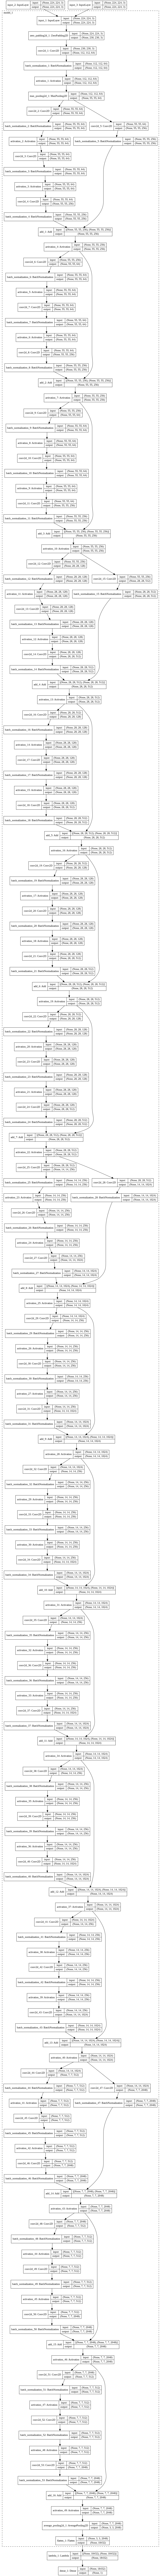

In [ ]:
from keras.utils import plot_model
plot_model(siamese_net,to_file='model.png',show_shapes=True,show_layer_names=True,expand_nested=True)

In [ ]:
PATH="/content/drive/My Drive/preprocessnew/preprocessnew_4"
with open(os.path.join(PATH, "train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())

training alphabets
dict_keys(['cel1', 'clarinet1', 'flute1', 'vio1', 'Gel1', 'sax1', 'tru1', 'voi1'])
validation alphabets:
dict_keys(['gac1', 'org1', 'piano1'])


In [ ]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h ,d= X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False) #makes an array of the training set with no repetation of class
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,d)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, d)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,d)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h,d = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:,:]]*N).reshape(N, w, h,d)
        support_set = X[categories,indices,:,:,:]
        support_set[0,:,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,d)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
PATH="/content/drive/My Drive/preprocessnew/preprocessnew_4"
        
loader = Siamese_Loader(PATH)

loading data from /content/drive/My Drive/preprocessnew/preprocessnew_4/train.pickle
loading data from /content/drive/My Drive/preprocessnew/preprocessnew_4/val.pickle


In [ ]:
print("!")
evaluate_every = 100 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size =5
n_iter = 10000
N_way = 2# how many classes for testing one-shot tasks>
n_val = 250#how mahy one-shot tasks to validate on?
best = -1
x = list()
y = list()
z=list()
p=list()
weights_path = os.path.join(PATH, "weights2")
print("Starting training process!")
print("--------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    x.append(loss)
    y.append(i)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss)) 
    if i % evaluate_every == 0:
        print("evaluating")
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        z.append(val_acc)
        p.append(i)
        if val_acc >= best:
            print("saving")
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path))
            siamese_net.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))
plt.scatter(y, x)
plt.plot(y,x)
plt.show()
plt.scatter(z,p)
plt.plot(z,p)
plt.show()


Streaming output truncated to the last 5000 lines.
 ------------- 

Loss: 0.7537739872932434

 ------------- 

Loss: 0.6930081844329834

 ------------- 

Loss: 0.9538044333457947

 ------------- 

Loss: 0.8737925887107849

 ------------- 

Loss: 0.8464400768280029

 ------------- 

Loss: 0.7490783929824829

 ------------- 

Loss: 0.746525764465332

 ------------- 

Loss: 0.71087247133255

 ------------- 

Loss: 0.8303689360618591

 ------------- 

Loss: 0.680719792842865

 ------------- 

Loss: 0.6399418711662292

 ------------- 

Loss: 0.5474658608436584

 ------------- 

Loss: 0.6835004091262817

 ------------- 

Loss: 0.573380172252655

 ------------- 

Loss: 0.7146798372268677

 ------------- 

Loss: 0.6958005428314209

 ------------- 

Loss: 0.721998393535614

 ------------- 

Loss: 0.7160473465919495

 ------------- 

Loss: 0.690253496170044

 ------------- 

Loss: 0.6862539649009705

 ------------- 

Loss: 0.9501073360443115

 ------------- 

Loss: 0.5152455568313599

 ---------

KeyboardInterrupt: ignored

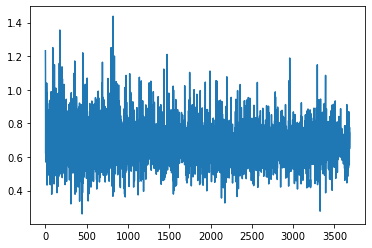

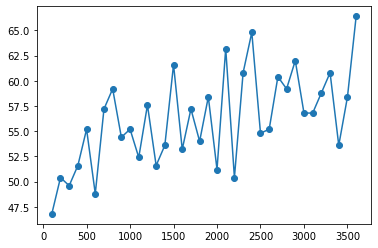

In [ ]:
plt.plot(y,x)
plt.show()
plt.scatter(p,z)
plt.plot(p,z)
plt.show()

In [ ]:
weights_path = os.path.join(PATH, "weights2")
siamese_net.load_weights(weights_path)

In [ ]:

def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [ ]:
iteration=1000
N_way=2
n_val=50
shot_accuracy=[]
nn_accuracy=[]

for i in range(1,200):
  one_shot= loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
  shot_accuracy.append(one_shot)
  nn=test_nn_accuracy(N_way,n_val,loader)
  nn_accuracy.append(nn)
max_one_shot=max(shot_accuracy)
max_nn=max(nn_accuracy)

Evaluating model on 50 random 2 way one-shot learning tasks ...
Got an average of 62.0% 2 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 2 way one-shot learning tasks ...


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Evaluating model on 50 random 2 way one-shot learning tasks ...
Got an average of 52.0% 2 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 2 way one-shot learning tasks ...
Evaluating model on 50 random 2 way one-shot learning tasks ...
Got an average of 56.0% 2 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 2 way one-shot learning tasks ...
Evaluating model on 50 random 2 way one-shot learning tasks ...
Got an average of 54.0% 2 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 2 way one-shot learning tasks ...
Evaluating model on 50 random 2 way one-shot learning tasks ...
Got an average of 64.0% 2 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 2 way one-shot learning tasks ...
Evaluating model on 50 random 2 way one-shot learning tasks ...
Got an average of 58.0% 2 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 2 way one-shot learning tasks ...
Evaluating mode

In [ ]:
from statistics import mean
max_one_shot=max(shot_accuracy)
max_nn=max(nn_accuracy)
mean_one_shot=mean(shot_accuracy)
mean_nn=mean(nn_accuracy)
#max_one_shot
#max_nn
#mean_one_shot
#mean_nn